In [1]:
# Load environment variables
import os
from dotenv import load_dotenv
load_dotenv()
IMAGES_PATH = os.getenv('IMAGES_PATH')
ROOT_DATA_PATH = os.getenv('ROOT_DATA_PATH')
BATCH_SIZE= int(os.getenv('BATCH_SIZE'))
EPOCHS = int(os.getenv('EPOCHS'))
LR = float(os.getenv('LR'))
PATCH_SIZE=int(os.getenv('PATCH_SIZE'))
DROPOUT=float(os.getenv('DROPOUT'))
ATTENTION_DROPOUT=float(os.getenv('ATTENTION_DROPOUT'))
HIDDEN_DIM=int(os.getenv('HIDDEN_DIM'))
MLP_DIM=int(os.getenv('MLP_DIM'))
NUM_HEADS=int(os.getenv('NUM_HEADS'))
NUM_LAYERS=int(os.getenv('NUM_LAYERS'))


In [ ]:
from preprocess.data_process import get_dataloaders

train_loader, val_loader, test_loader = get_dataloaders()

Train Set Size: 6000
Val Set Size: 200
Test Set Size: 500


In [3]:
import torch
from torchvision.models import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(image_size=80, patch_size=PATCH_SIZE, num_layers=NUM_LAYERS, 
                                       num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, 
                                       mlp_dim=MLP_DIM, dropout=DROPOUT,
                                       attention_dropout=ATTENTION_DROPOUT,
                                       num_classes=2)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [4]:
from torchinfo import summary

summary(model, input_size=(64, 3, 80, 80), device='cuda')

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [64, 2]                   768
├─Conv2d: 1-1                                 [64, 768, 8, 8]           231,168
├─Encoder: 1-2                                [64, 65, 768]             49,920
│    └─Dropout: 2-1                           [64, 65, 768]             --
│    └─Sequential: 2-2                        [64, 65, 768]             --
│    │    └─EncoderBlock: 3-1                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [64, 65, 768]             7,087,872
│    └─LayerNorm: 2-3                      

In [5]:
loss_fn_transformer = lambda output, labels: loss_fn(output, torch.nn.functional.one_hot(labels, num_classes=2).float())

In [6]:
from timeit import default_timer as timer
from tqdm import tqdm
from utilities import train_step, val_step
import pandas as pd
import numpy as np
train_start_time = timer()

print(f"Training on Device: {device}")
model.to(device)

train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

min_val_loss = np.inf

os.environ["MODEL_TYPE"] = "transformer"

# Create two empty dataframes to store loss and accuracy values
train_metrics = pd.DataFrame(columns=["train_loss", "train_acc"])
val_metrics = pd.DataFrame(columns=["val_loss", "val_acc"])
test_metrics = pd.DataFrame(columns=["test_loss", "test_acc"])
print("-----------Training starting----------")
for epoch in tqdm(range(0, EPOCHS), unit="EPOCHS", desc="Training (with per-epoch validation):"):
    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Train the model
    train_loss, train_acc = train_step(model, loss_fn_transformer, optimizer, device, train_loader)
    train_metrics.loc[epoch, 'train_loss']= train_loss
    train_metrics.loc[epoch, 'train_acc'] = train_acc

    val_loss, val_acc, min_val_loss = val_step(model, loss_fn_transformer, device, min_val_loss, val_loader)
    val_metrics.loc[epoch, 'val_loss'] = val_loss
    val_metrics.loc[epoch, 'val_acc'] = val_acc
print("-----------Training finished----------")

train_end_time = timer()

total_train_time = train_end_time - train_start_time

print(f"Training completed in {total_train_time:.2f} seconds or {total_train_time/60:.2f} minutes")

Training on Device: cuda
-----------Training starting----------


Training (with per-epoch validation)::   0%|          | 0/100 [00:00<?, ?EPOCHS/s]

		Validation Loss Decreased (inf) --->0.672062 	 Saving model


Training (with per-epoch validation)::   1%|          | 1/100 [00:05<09:36,  5.82s/EPOCHS]

		Validation Loss Decreased (0.672062) --->0.476095 	 Saving model


Training (with per-epoch validation)::   2%|▏         | 2/100 [00:11<09:24,  5.76s/EPOCHS]

		Validation Loss Decreased (0.476095) --->0.435594 	 Saving model


Training (with per-epoch validation)::   3%|▎         | 3/100 [00:17<09:44,  6.03s/EPOCHS]

		Validation Loss Decreased (0.435594) --->0.369029 	 Saving model


Training (with per-epoch validation)::   4%|▍         | 4/100 [00:23<09:29,  5.93s/EPOCHS]

		Validation Loss Decreased (0.369029) --->0.272323 	 Saving model


Training (with per-epoch validation)::   5%|▌         | 5/100 [00:29<09:19,  5.89s/EPOCHS]

		Validation Loss Decreased (0.272323) --->0.230546 	 Saving model


Training (with per-epoch validation)::   7%|▋         | 7/100 [00:40<08:53,  5.73s/EPOCHS]

		Validation Loss Decreased (0.230546) --->0.189221 	 Saving model


Training (with per-epoch validation)::  15%|█▌        | 15/100 [01:26<08:02,  5.68s/EPOCHS]

		Validation Loss Decreased (0.189221) --->0.146803 	 Saving model


Training (with per-epoch validation)::  18%|█▊        | 18/100 [01:43<07:51,  5.75s/EPOCHS]

		Validation Loss Decreased (0.146803) --->0.142599 	 Saving model


Training (with per-epoch validation)::  19%|█▉        | 19/100 [01:49<07:52,  5.83s/EPOCHS]

		Validation Loss Decreased (0.142599) --->0.131054 	 Saving model


Training (with per-epoch validation):: 100%|██████████| 100/100 [10:31<00:00,  6.31s/EPOCHS]

-----------Training finished----------
Training completed in 631.03 seconds or 10.52 minutes


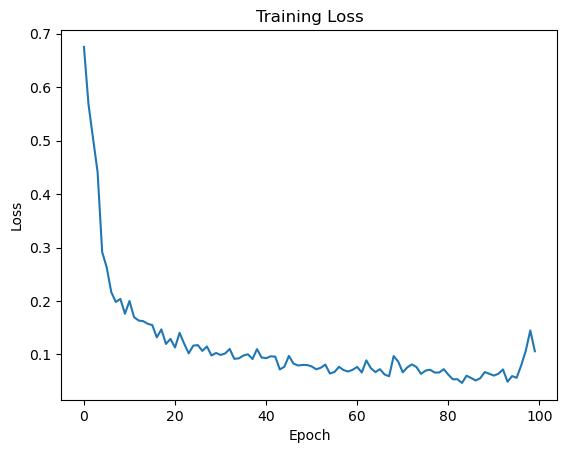

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_metrics['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

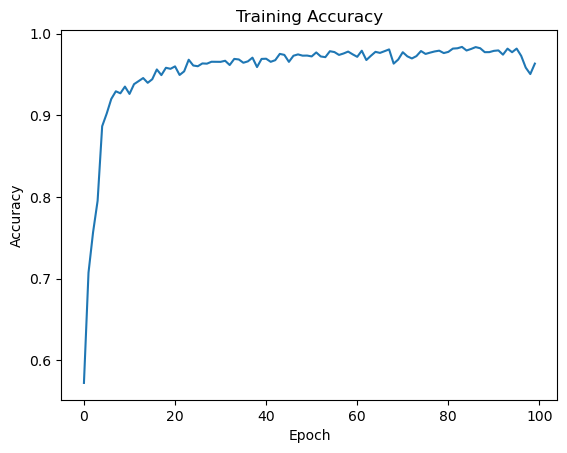

In [8]:
plt.plot(train_metrics['train_acc'])
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show() 

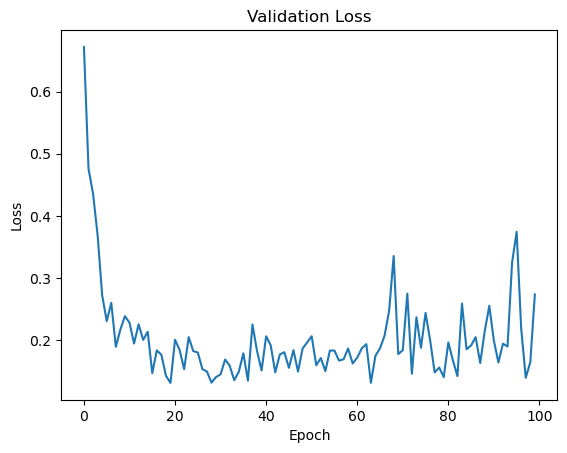

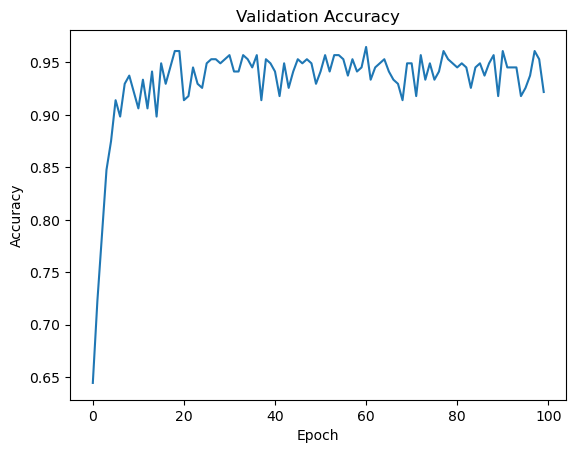

In [9]:
plt.plot(val_metrics['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show() 
plt.plot(val_metrics['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show() 

In [10]:
from utilities import test_step

# Testing
test_start_time = timer()

print("-----------Testing starting----------")

test_results = test_step(model, loss_fn_transformer, device, test_loader, use_tqdm=True)

print("-----------Testing finished----------")

test_end_time = timer()

total_test_time = test_end_time - test_start_time

print(f"Testing completed in {total_test_time:.2f} seconds")

-----------Testing starting----------


Testing: 100%|██████████| 8/8 [00:00<00:00, 62.15batches/s]

-----------Testing finished----------
Testing completed in 0.13 seconds


In [16]:
def save_metrics(train_metrics: pd.DataFrame, val_metrics: pd.DataFrame, test_metrics: pd.DataFrame):
    """
    Saves the stored metrics from the training, validation, and test metric DataFrame objects.
    Metrics stored in 'results/MODEL_TYPE' with MODEL_TYPE as the configured model that was just trained.
    MODEL_TYPE is intended to be configured before training as an environment variable.

    Args:
        train_metrics (pd.DataFrame): Training metrics DataFrame object.
        val_metrics (pd.DataFrame): Validation metrics DataFrame object.
        test_metrics (pd.DataFrame): Test metrics DataFrame object.
    
    Returns:
        None

    """
    MODEL_TYPE = str(os.getenv("MODEL_TYPE"))

    # Save metrics to csv
    train_metrics.to_csv("results/" + MODEL_TYPE + "/train_metrics.csv", index=True)
    val_metrics.to_csv("results/" + MODEL_TYPE + "/val_metrics.csv", index=True)
    test_metrics.to_csv("results/"+ MODEL_TYPE + "/test_metrics.csv", index=True)

    # Save metric plots

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].set_title("Training and Validation Loss")
    axs[0].plot(train_metrics['train_loss'], label='Training Loss')
    axs[0].plot(val_metrics['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    axs[1].set_title("Training and Validation Accuracy")
    axs[1].plot(train_metrics['train_acc'], label='Training Accuracy')
    axs[1].plot(val_metrics['val_acc'], label='Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("results/" + MODEL_TYPE + "/train_val__loss_accuracy_plot.png")
    plt.close()

    fig, axs = plt.subplots(2, figsize=(8, 6))
    axs[0].set_title("Testing Loss")
    axs[0].plot(test_metrics['test_loss'], label='Test Loss')
    axs[0].set_xlabel('Batches')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].set_title("Testing Accuracy")
    axs[1].plot(test_metrics['test_acc'], label='Testing Accuracy')
    axs[1].set_xlabel('Batches')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.tight_layout()
    plt.savefig("results/" + MODEL_TYPE + "/test_loss_accuracy_plot.png")
    plt.close()


In [17]:
# from utilities import save_metrics

# Save metrics
save_metrics(train_metrics, val_metrics, test_results)

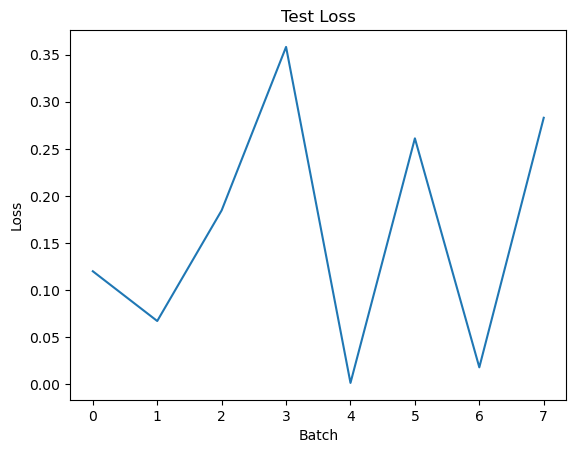

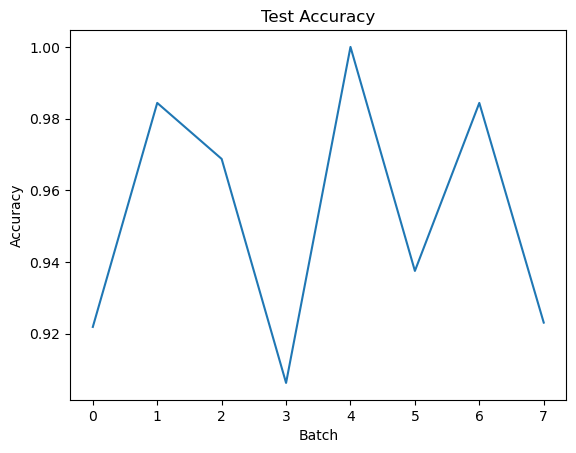

In [11]:
plt.plot(test_results["test_loss"])
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show() 
plt.plot(test_results['test_acc'])
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')   
plt.show()

In [15]:
print(f"Average Test Loss: {test_results['test_loss'].mean():.4f}")
print(f"Average Test Accuracy: {test_results['test_acc'].mean() * 100:.4f}%")

Average Test Loss: 0.1617
Average Test Accuracy: 95.3275%
